In [2]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
train_label = pd.read_csv('多标签图像检索挑战赛公开数据/train_label.csv', header=None)
test_query = pd.read_csv('多标签图像检索挑战赛公开数据/test_query.csv', header=None)

train_label[0] = './多标签图像检索挑战赛公开数据/train/' + train_label[0]
train_label[1] = train_label[1].apply(eval)

test_paths = glob.glob('./多标签图像检索挑战赛公开数据/test/*.jpg')
test_paths = np.array(test_paths)

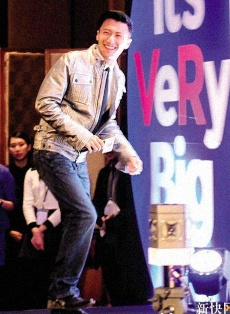

In [23]:
Image.open(train_label.iloc[0][0])

In [24]:
train_label.iloc[0][1]

['地站', '舞台', '话筒', '男人']

In [43]:
train_label_tags = sum(train_label[1], [])
train_label_tags = np.array(list(set(train_label_tags)))

# 加载CLIP模型

In [26]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

# https://huggingface.co/OFA-Sys/chinese-clip-vit-base-patch16
model = ChineseCLIPModel.from_pretrained("./chinese-clip-vit-base-patch16")
processor = ChineseCLIPProcessor.from_pretrained("./chinese-clip-vit-base-patch16")

In [29]:
_ = model.to('cuda')

# 训练集图像编码

In [34]:
img_image_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(train_label) // batch_size + 1)):
    imgs = [ Image.open(path) for path in train_label[0].iloc[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    inputs = {k:v.to('cuda') for k,v in inputs.items()}
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.cpu().numpy()
        img_image_feat.append(image_features)
        
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

/tmp/ipykernel_5159/795001972.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(train_label) // batch_size + 1)):


  0%|          | 0/751 [00:00<?, ?it/s]

# 训练集文本编码

In [39]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(train_label_tags) // batch_size + 1)):
    texts = [ text for text in train_label_tags[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)
    inputs = {k:v.to('cuda') for k,v in inputs.items()}

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.cpu().numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

/tmp/ipykernel_5159/211017471.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(train_label_tags) // batch_size + 1)):


  0%|          | 0/219 [00:00<?, ?it/s]

# 图片检索文本

In [55]:
query_idx = 650

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][:10]

In [56]:
train_label_tags[sim_idx]

array(['扎起', '上玩自', '勾肩搭背', '奇装异服', '后撑地', '上量', '上抖', '橘黄色', '发上', '揣进'],
      dtype='<U5')

([], [])

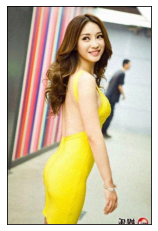

In [57]:
plt.imshow(Image.open(train_label[0].iloc[query_idx]))
plt.xticks([]); plt.yticks([])

# 文本检索图片

In [58]:
query_idx = 650

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T)
sim_idx = sim_result.argsort()[::-1][:10]

In [61]:
train_label_tags[query_idx]

'脱鞋'

([], [])

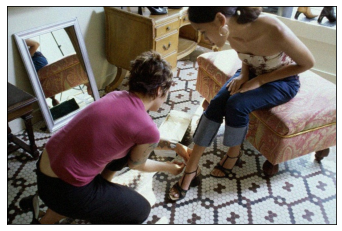

In [59]:
plt.imshow(Image.open(train_label[0].iloc[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

# 测试集图片编码

In [64]:
img_image_feat_test = []

batch_size = 20
for idx in tqdm_notebook(range(len(test_paths) // batch_size + 1)):
    imgs = [ Image.open(path) for path in test_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    inputs = {k:v.to('cuda') for k,v in inputs.items()}
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.cpu().numpy()
        img_image_feat_test.append(image_features)
        
img_image_feat_test = np.vstack(img_image_feat_test)
img_image_feat_test = normalize(img_image_feat_test)

/tmp/ipykernel_5159/1445231175.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(test_paths) // batch_size + 1)):


  0%|          | 0/1251 [00:00<?, ?it/s]

# 测试集文本编码

In [68]:
test_query = test_query[0].apply(lambda x: ' '.join(eval(x)))

In [69]:
img_texts_feat_test = []

batch_size = 20
for idx in tqdm_notebook(range(len(test_query) // batch_size + 1)):
    texts = [ text for text in test_query.iloc[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)
    inputs = {k:v.to('cuda') for k,v in inputs.items()}

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.cpu().numpy()
        img_texts_feat_test.append(text_features)
        
img_texts_feat_test = np.vstack(img_texts_feat_test)
img_texts_feat_test = normalize(img_texts_feat_test)

/tmp/ipykernel_5159/94193606.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(test_query) // batch_size + 1)):


  0%|          | 0/1251 [00:00<?, ?it/s]

# 生成提交结果

In [91]:
query_idx = 95
sim_result = np.dot(img_texts_feat_test[query_idx], img_image_feat_test.T)
sim_idx = sim_result.argsort()[::-1][:10]

In [92]:
test_query.iloc[query_idx]

'短裤 穿着 双脚 草地 女人 双手 麻花 放在'

([], [])

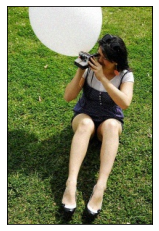

In [93]:
plt.imshow(Image.open(test_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

In [89]:
with open('submit.csv', 'w') as up:
    for idx in range(len(img_texts_feat_test)):
        sim_result = np.dot(img_texts_feat_test[idx], img_image_feat_test.T)
        sim_idx = sim_result.argsort()[::-1][:5]
        pred_paths = test_paths[sim_idx]
        pred_paths = [x.split('/')[-1] for x in pred_paths]
        up.write(','.join(pred_paths) + '\n')